# Project 4: Web Scraping Job Postings

## Business Case Overview

You're working as a data scientist for a contracting firm that's rapidly expanding. Now that they have their most valuable employee (you!), they need to leverage data to win more contracts. Your firm offers technology and scientific solutions and wants to be competitive in the hiring market. Your principal has two main objectives:

   1. Determine the industry factors that are most important in predicting the salary amounts for these data.
   2. Determine the factors that distinguish job categories and titles from each other. For example, can required skills accurately predict job title?

To limit the scope, your principal has suggested that you *focus on data-related job postings*, e.g. data scientist, data analyst, research scientist, business intelligence, and any others you might think of. You may also want to decrease the scope by *limiting your search to a single region.*

## Directions

In this project you will be leveraging a variety of skills. The first will be to use the web-scraping and/or API techniques you've learned to collect data on data jobs from Indeed.com or another aggregator. Once you have collected and cleaned the data, you will use it to answer the two questions described above.

### QUESTION 1: Factors that impact salary

To predict salary you will be building either a classification or regression model, using features like the location, title, and summary of the job. If framing this as a regression problem, you will be estimating the listed salary amounts. You may instead choose to frame this as a classification problem, in which case you will create labels from these salaries (high vs. low salary, for example) according to thresholds (such as median salary).

You have learned a variety of new skills and models that may be useful for this problem:
- NLP
- Unsupervised learning and dimensionality reduction techniques (PCA, clustering)
- Ensemble methods and decision tree models
- SVM models

Whatever you decide to use, the most important thing is to justify your choices and interpret your results. *Communication of your process is key.* Note that most listings **DO NOT** come with salary information. You'll need to able to extrapolate or predict the expected salaries for these listings.

### QUESTION 2: Factors that distinguish job category

Using the job postings you scraped for part 1 (or potentially new job postings from a second round of scraping), identify features in the data related to job postings that can distinguish job titles from each other. There are a variety of interesting ways you can frame the target variable, for example:
- What components of a job posting distinguish data scientists from other data jobs?
- What features are important for distinguishing junior vs. senior positions?
- Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

You may end up making multiple classification models to tackle different questions. Be sure to clearly explain your hypotheses and framing, any feature engineering, and what your target variables are. The type of classification model you choose is up to you. Be sure to interpret your results and evaluate your models' performance.


### BONUS PROBLEM

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs. Plot the ROC curve.

## Solution

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import roc_curve, auc

### Load the Scraped Web Data from Database

In [2]:
# Load only the data with salary
db_conn = sqlite3.connect('project-04-starter.db')
db_curr = db_conn.cursor()
db_jobs = db_curr.execute('SELECT * FROM JOBS WHERE SALARY_FROM <> "$0"')

In [3]:
db_jobs = db_jobs.fetchall()
db_curr.close()

In [4]:
df_jobs_raw = pd.DataFrame(db_jobs, columns=['JobId', 'JobTitle', 'Company', 'CompanyAddress', 'CountryCode', 
                                             'JobType', 'JobIndustry', 'JobLevel', 'SalaryFrom', 'SalaryTo', 
                                             'Roles', 'Requirements', 'JobSite', 'JobTags', 'URL'])
df_jobs_raw.head()

,JobId,JobTitle,Company,CompanyAddress,CountryCode,JobType,JobIndustry,JobLevel,SalaryFrom,SalaryTo,Roles,Requirements,JobSite,JobTags,URL
0,1284,Data Scientist - Business Analytics,INFINEON TECHNOLOGIES ASIA PACIFIC PTE LTD,"INFINEON, 8 KALLANG SECTOR 349282",SG,Permanent,Information Technology,"Professional, Executive, Senior Executive","$6,000","to$10,000",Roles & Responsibilities\nIn your new role you...,Requirements\nYou are best equipped for this t...,https://www.mycareersfuture.sg/,data scientist,https://www.mycareersfuture.sg/job/data-scient...
1,1285,Data Scientist,ALPHATECH BUSINESS SOLUTIONS PTE. LTD.,,SG,"Permanent, Full Time",Information Technology,Professional,"$5,500","to$8,000",Roles & Responsibilities\n· Use machine ...,Requirements\n· Atleast 3+ years of Deep...,https://www.mycareersfuture.sg/,data scientist,https://www.mycareersfuture.sg/job/data-scient...
2,1286,Data Scientist,ITPM CONSULTING PTE. LTD.,"BANK OF SINGAPORE CENTRE, 63 MARKET STREET 048942",SG,"Permanent, Full Time",Information Technology,Professional,"$7,000","to$8,500",Roles & Responsibilities\nITPM Consulting Pte ...,Requirements\nResearch and develop statistical...,https://www.mycareersfuture.sg/,data scientist,https://www.mycareersfuture.sg/job/data-scient...
3,1289,Data Scientist,GO-JEK SINGAPORE PTE. LTD.,"AXA TOWER, 8 SHENTON WAY 068811",SG,Permanent,Information Technology,Junior Executive,"$6,000","to$8,000",Roles & Responsibilities\nGOJEK is the largest...,Requirements\nWhat we are looking for:\nYou gr...,https://www.mycareersfuture.sg/,data scientist,https://www.mycareersfuture.sg/job/data-scient...
4,1290,Data Scientist,GO-JEK SINGAPORE PTE. LTD.,"AXA TOWER, 8 SHENTON WAY 068811",SG,Permanent,Information Technology,Junior Executive,"$6,000","to$8,000",Roles & Responsibilities\nGOJEK is the largest...,Requirements\nWhat we are looking for:\nYou gr...,https://www.mycareersfuture.sg/,data scientist,https://www.mycareersfuture.sg/job/data-scient...


In [5]:
df_jobs_raw.shape

(930, 15)

### EDA

In [6]:
# Check if there are missing values
df_jobs_raw.isna().any().any()

False

In [7]:
df_jobs = df_jobs_raw.copy()

In [8]:
# Remove Invalid Characters from the Salary
df_jobs['SalaryFrom'] = df_jobs['SalaryFrom'].apply(lambda x: x.replace('$',''))
df_jobs['SalaryFrom'] = df_jobs['SalaryFrom'].apply(lambda x: x.replace(',',''))
df_jobs['SalaryFrom'] = df_jobs['SalaryFrom'].astype(int)

df_jobs['SalaryTo'] = df_jobs['SalaryTo'].apply(lambda x: x.replace('$',''))
df_jobs['SalaryTo'] = df_jobs['SalaryTo'].apply(lambda x: x.replace(',',''))
df_jobs['SalaryTo'] = df_jobs['SalaryTo'].apply(lambda x: x.replace('to',''))
df_jobs['SalaryTo'] = df_jobs['SalaryTo'].astype(int)

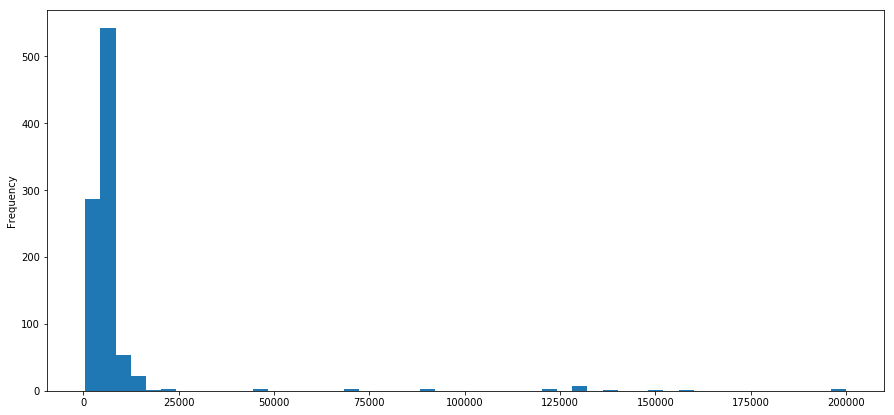

In [9]:
# Check the Range of the SalariesFrom
df_jobs['SalaryFrom'].plot(kind='hist', bins=50, figsize=(15,7))

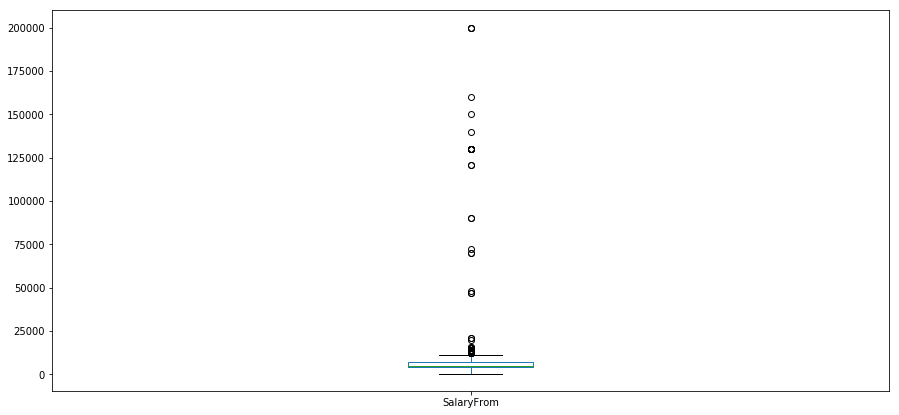

In [10]:
df_jobs['SalaryFrom'].plot(kind='box', figsize=(15,7))

In [11]:
# Check the abnormal range of values
df_jobs[df_jobs['SalaryFrom']>20000].sort_values('SalaryFrom', ascending='False')

,JobId,JobTitle,Company,CompanyAddress,CountryCode,JobType,JobIndustry,JobLevel,SalaryFrom,SalaryTo,Roles,Requirements,JobSite,JobTags,URL
29,1316,"Vice President, Data Scientist - Corporate",NOMURA SINGAPORE LIMITED,"MARINA BAY FINANCIAL CENTRE, 10 MARINA BOULEVA...",SG,Full Time,Banking and Finance,Professional,20800,33500,Roles & Responsibilities\nNomura Overview \nN...,Requirements\nKey Experience & Skills \nStron...,https://www.mycareersfuture.sg/,data scientist,https://www.mycareersfuture.sg/job/vice-presid...
540,1870,"Vice President, Data Scientist - Corporate",NOMURA SINGAPORE LIMITED,"MARINA BAY FINANCIAL CENTRE, 10 MARINA BOULEVA...",SG,Full Time,Banking and Finance,Professional,20800,33500,Roles & Responsibilities\nNomura Overview \nN...,Requirements\nKey Experience & Skills \nStron...,https://www.mycareersfuture.sg/,machine learning,https://www.mycareersfuture.sg/job/vice-presid...
569,1904,Research Engineer / Research Fellow,NATIONAL UNIVERSITY OF SINGAPORE,21 LOWER KENT RIDGE ROAD 119077,SG,"Contract, Full Time","Engineering, Sciences / Laboratory / R&D",Non-executive,46800,78000,Roles & Responsibilities\nThe Department of El...,Requirements\nA recognised Degree / PhD in Eng...,https://www.mycareersfuture.sg/,machine learning,https://www.mycareersfuture.sg/job/research-en...
216,1523,Research Engineer / Research Fellow,NATIONAL UNIVERSITY OF SINGAPORE,21 LOWER KENT RIDGE ROAD 119077,SG,"Contract, Full Time","Engineering, Sciences / Laboratory / R&D",Non-executive,46800,78000,Roles & Responsibilities\nThe Department of El...,Requirements\nA recognised Degree / PhD in Eng...,https://www.mycareersfuture.sg/,deep learning,https://www.mycareersfuture.sg/job/research-en...
489,1818,Research Fellow,NATIONAL UNIVERSITY OF SINGAPORE,21 LOWER KENT RIDGE ROAD 119077,SG,Contract,Sciences / Laboratory / R&D,Non-executive,48000,95000,Roles & Responsibilities\nWe are looking for p...,Requirements\n- PhD in Computer Science or rel...,https://www.mycareersfuture.sg/,machine learning,https://www.mycareersfuture.sg/job/research-fe...
470,1796,Infrastructure SME,SYNECHRON BUSINESS CONSULTING PTE. LTD.,"ONE RAFFLES PLACE, 1 RAFFLES PLACE 048616",SG,"Permanent, Full Time",Information Technology,Professional,70000,100000,Roles & Responsibilities\nSynechron draws on o...,Requirements\nInfrastructure SME\nOverall 8+ Y...,https://www.mycareersfuture.sg/,machine learning,https://www.mycareersfuture.sg/job/infrastruct...
387,1702,Infrastructure SME,SYNECHRON BUSINESS CONSULTING PTE. LTD.,"ONE RAFFLES PLACE, 1 RAFFLES PLACE 048616",SG,"Permanent, Full Time",Information Technology,Professional,70000,100000,Roles & Responsibilities\nSynechron draws on o...,Requirements\nInfrastructure SME\nOverall 8+ Y...,https://www.mycareersfuture.sg/,artificial intelligence,https://www.mycareersfuture.sg/job/infrastruct...
837,2200,Software Development Test Engineer,SPM STRATEGIC PTE. LTD.,"GRAND BUILDING, 17 PHILLIP STREET 048695",SG,"Permanent, Full Time",Information Technology,Professional,72000,90000,Roles & Responsibilities\nRESPONSIBILITIES\nDe...,Requirements\nREQUIREMENTS\n5+ years of test a...,https://www.mycareersfuture.sg/,python,https://www.mycareersfuture.sg/job/software-de...
834,2197,DevOps Manager,COMPANY UNDISCLOSED,,SG,Full Time,Information Technology,Middle Management,90000,145000,Roles & Responsibilities\nOverview\nTT is seek...,Requirements\nQualifications:\n3+ years managi...,https://www.mycareersfuture.sg/,python,https://www.mycareersfuture.sg/job/devops-mana...
465,1791,Product Analytics Manager - Machine Learning,VISA WORLDWIDE PTE. LIMITED,,SG,"Permanent, Full Time",Others,Manager,90000,180000,Roles & Responsibilities\nProduct Analytics Ma...,Requirements\nDirecting and executing multiple...,https://www.mycareersfuture.sg/,machine learning,https://www.mycareersfuture.sg/job/product-ana...


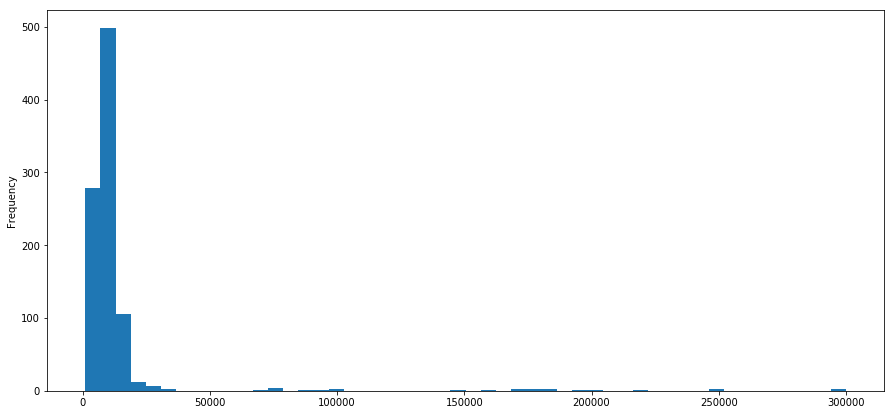

In [12]:
# Check the Range of the SalariesTo
df_jobs['SalaryTo'].plot(kind='hist', bins=50, figsize=(15,7))

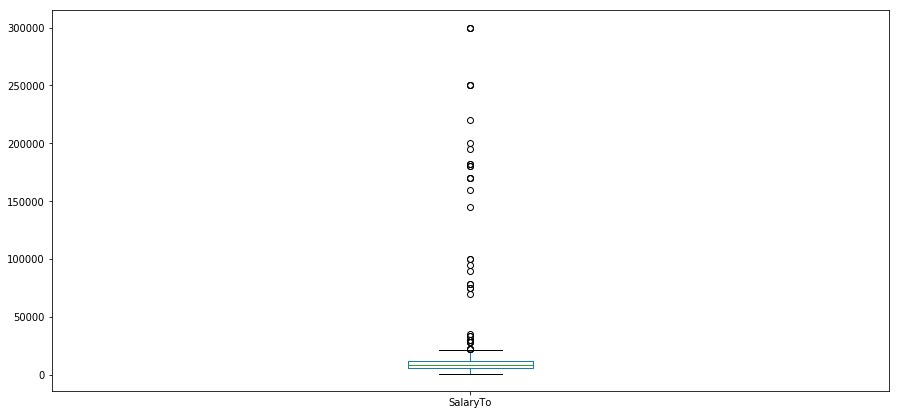

In [13]:
df_jobs['SalaryTo'].plot(kind='box', figsize=(15,7))

In [14]:
# Check the abnormal range of values
df_jobs[df_jobs['SalaryTo']>100000].sort_values('SalaryTo', ascending='False')

,JobId,JobTitle,Company,CompanyAddress,CountryCode,JobType,JobIndustry,JobLevel,SalaryFrom,SalaryTo,Roles,Requirements,JobSite,JobTags,URL
834,2197,DevOps Manager,COMPANY UNDISCLOSED,,SG,Full Time,Information Technology,Middle Management,90000,145000,Roles & Responsibilities\nOverview\nTT is seek...,Requirements\nQualifications:\n3+ years managi...,https://www.mycareersfuture.sg/,python,https://www.mycareersfuture.sg/job/devops-mana...
23,1310,Data Scientist,EXIGER SINGAPORE PTE. LTD.,"OCBC CENTRE, 65 CHULIA STREET 049513",SG,"Permanent, Full Time","Information Technology, Professional Services",Professional,12000,160000,Roles & Responsibilities\nPosition Summary\nWe...,Requirements\nProfessional Experience Required...,https://www.mycareersfuture.sg/,data scientist,https://www.mycareersfuture.sg/job/data-scient...
328,1640,Data Engineer,CHUBB ASIA PACIFIC PTE. LTD.,"CAPITAGREEN, 138 MARKET STREET 048946",SG,Contract,Information Technology,Non-executive,130000,170000,Roles & Responsibilities\nIdeal candidate will...,"Requirements\nQualifications, Skills and Exper...",https://www.mycareersfuture.sg/,data engineer,https://www.mycareersfuture.sg/job/data-engine...
459,1783,Cloud Solution Architect,MICROSOFT OPERATIONS PTE LTD,,SG,Full Time,Information Technology,Non-executive,140000,170000,Roles & Responsibilities\nMicrosoft envisions ...,Requirements\nExperiences Required – Education...,https://www.mycareersfuture.sg/,artificial intelligence,https://www.mycareersfuture.sg/job/cloud-solut...
631,1968,Data Engineer,CHUBB ASIA PACIFIC PTE. LTD.,"CAPITAGREEN, 138 MARKET STREET 048946",SG,Contract,Information Technology,Non-executive,130000,170000,Roles & Responsibilities\nIdeal candidate will...,"Requirements\nQualifications, Skills and Exper...",https://www.mycareersfuture.sg/,machine learning,https://www.mycareersfuture.sg/job/data-engine...
465,1791,Product Analytics Manager - Machine Learning,VISA WORLDWIDE PTE. LIMITED,,SG,"Permanent, Full Time",Others,Manager,90000,180000,Roles & Responsibilities\nProduct Analytics Ma...,Requirements\nDirecting and executing multiple...,https://www.mycareersfuture.sg/,machine learning,https://www.mycareersfuture.sg/job/product-ana...
528,1857,Quantitative Specialist for Op Risk and Monito...,UBS AG,1 RAFFLES QUAY 048583,SG,Full Time,Banking and Finance,Senior Executive,150000,180000,Roles & Responsibilities\nAre you an expert in...,Requirements\nThe role requires a mix of exper...,https://www.mycareersfuture.sg/,machine learning,https://www.mycareersfuture.sg/job/quantitativ...
666,2004,Partner Solutions Professional,MICROSOFT OPERATIONS PTE LTD,,SG,Full Time,Information Technology,Non-executive,121000,182000,Roles & Responsibilities\nMicrosoft’s Mission:...,Requirements\nIdeal Candidate:\nUnderstanding ...,https://www.mycareersfuture.sg/,machine learning,https://www.mycareersfuture.sg/job/partner-sol...
444,1766,Partner Solutions Professional,MICROSOFT OPERATIONS PTE LTD,,SG,Full Time,Information Technology,Non-executive,121000,182000,Roles & Responsibilities\nMicrosoft’s Mission:...,Requirements\nIdeal Candidate:\nUnderstanding ...,https://www.mycareersfuture.sg/,artificial intelligence,https://www.mycareersfuture.sg/job/partner-sol...
283,1593,APCJ Data Center Partner Systems Engineer,CISCO SYSTEMS (USA) PTE. LTD.,"ONE MARINA BOULEVARD, 1 MARINA BOULEVARD 018989",SG,"Permanent, Full Time",Information Technology,Professional,130000,195000,Roles & Responsibilities\nAPJ Partner Engineer...,Requirements\nCompetencies & Behaviors\nCreati...,https://www.mycareersfuture.sg/,data engineer,https://www.mycareersfuture.sg/job/apcj-data-c...


In [15]:
# Perform cleanup
df_jobs['SalaryTo'] = np.where(df_jobs['SalaryFrom'] > 20000, df_jobs['SalaryTo']/12, df_jobs['SalaryTo'])
df_jobs['SalaryFrom'] = np.where(df_jobs['SalaryFrom'] > 20000, df_jobs['SalaryFrom']/12, df_jobs['SalaryFrom'])

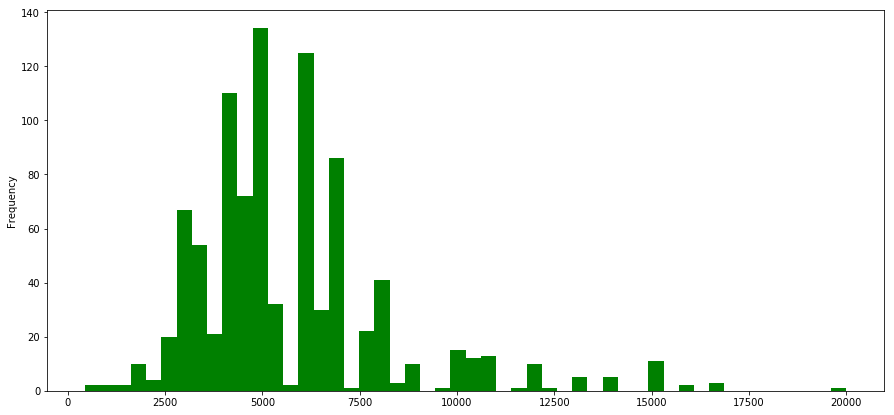

In [16]:
# SalaryFrom looks OK already after cleanup
df_jobs['SalaryFrom'].plot(kind='hist', bins=50, figsize=(15,7), color='green')

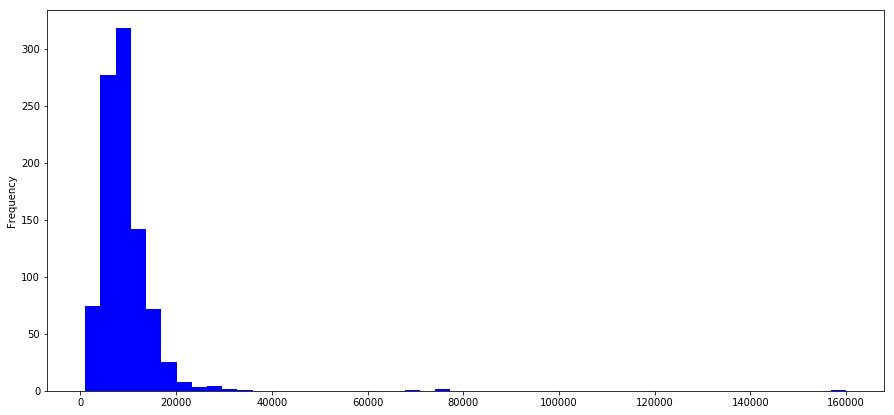

In [17]:
# SalaryTo is still not OK
df_jobs['SalaryTo'].plot(kind='hist', bins=50, figsize=(15,7), color='b')

In [18]:
# Perform cleanup
df_jobs['SalaryTo'] = np.where(df_jobs['SalaryTo'] > 100000, df_jobs['SalaryTo']/12, df_jobs['SalaryTo'])

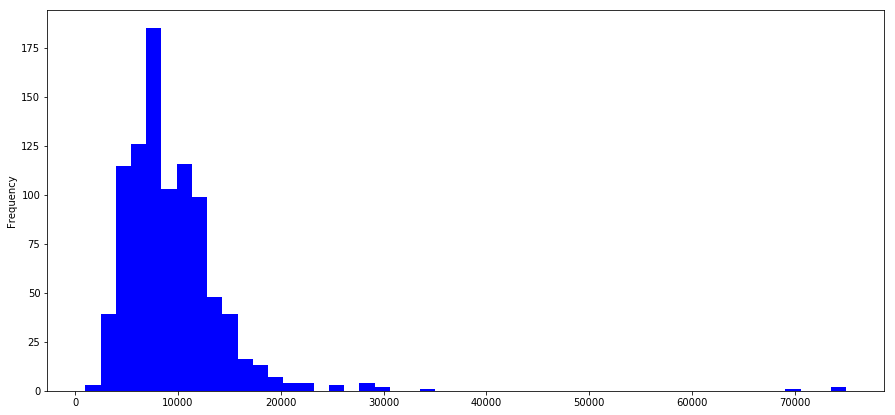

In [19]:
# SalaryTo is now OK
df_jobs['SalaryTo'].plot(kind='hist', bins=50, figsize=(15,7), color='blue')

In [20]:
# Create a New Column to get the Mean of Salary Range
df_jobs['SalaryMean'] = (df_jobs['SalaryFrom'] + df_jobs['SalaryTo']) / 2

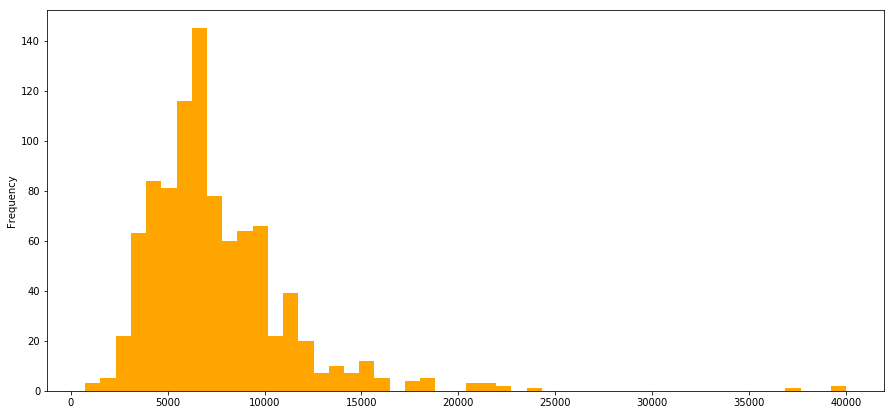

In [21]:
df_jobs['SalaryMean'].plot(kind='hist', bins=50, figsize=(15,7), color='orange')

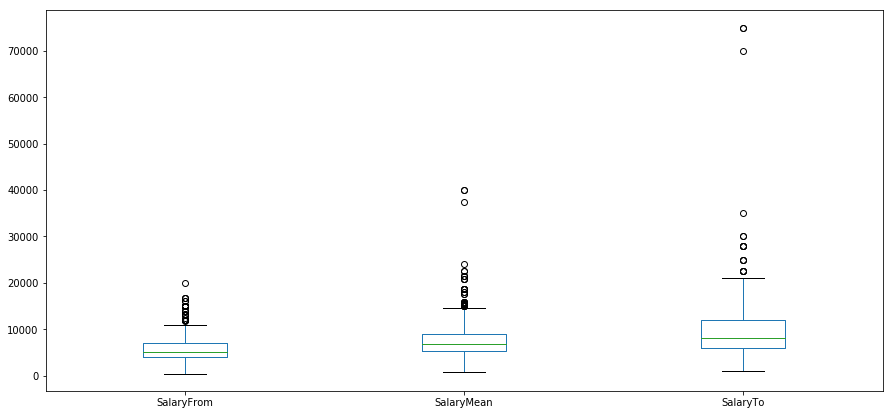

In [22]:
df_jobs[['SalaryFrom', 'SalaryMean', 'SalaryTo']].plot(kind='box', figsize=(15,7))

In [23]:
# Create a Flag to Indicate whether the Job Posting is High Salary or Not
df_jobs['HighSalary'] = np.where(df_jobs['SalaryMean'] > np.median(df_jobs['SalaryMean']), 1, 0)

In [24]:
# Check the Distribution of Salary Indicator between High and Non High
df_jobs['HighSalary'].value_counts()

0    468
1    462
Name: HighSalary, dtype: int64

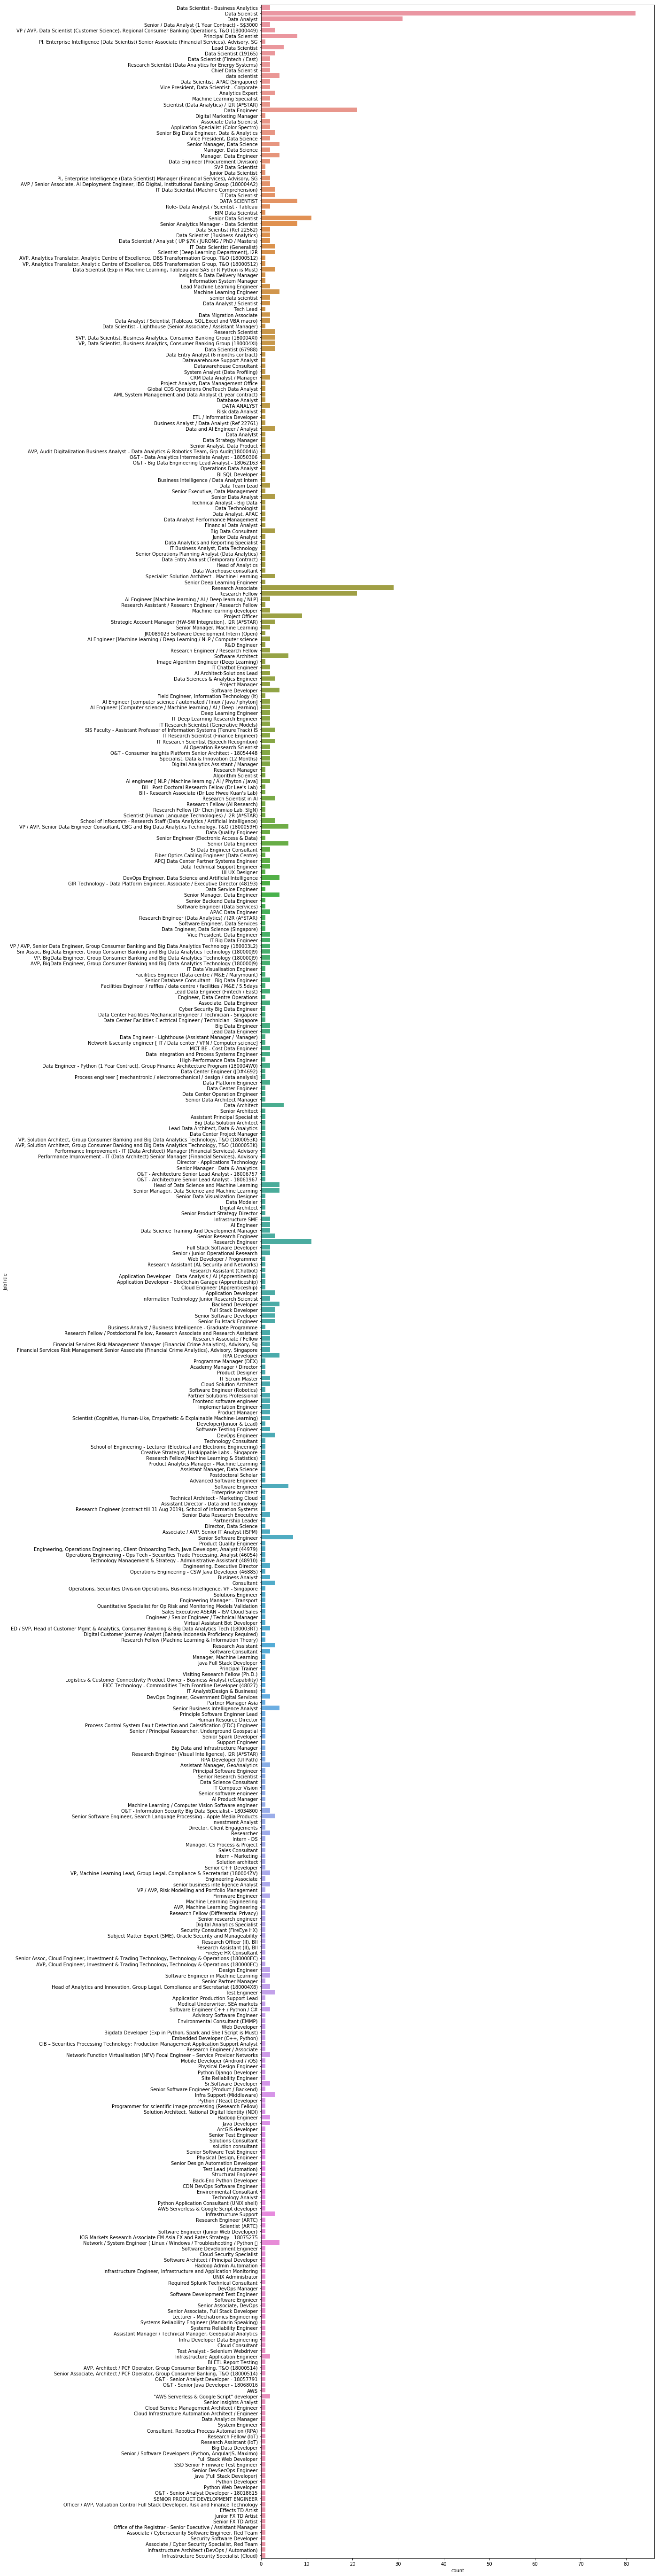

In [25]:
# Plot the Count of Job Titles
plt.figure(figsize=(15, 100))
sns_jobtype = sns.countplot(y='JobTitle', data=df_jobs)

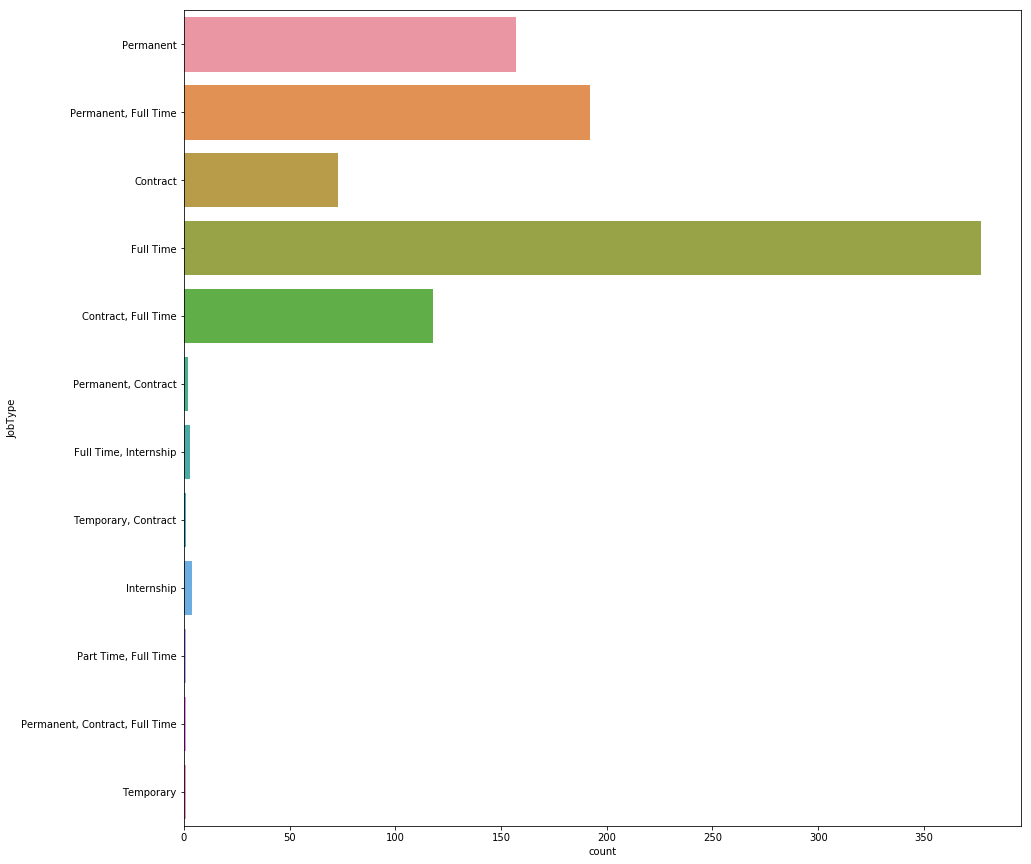

In [26]:
# Plot the Count of Job Types
plt.figure(figsize=(15, 15))
sns_jobtype = sns.countplot(y='JobType', data=df_jobs)

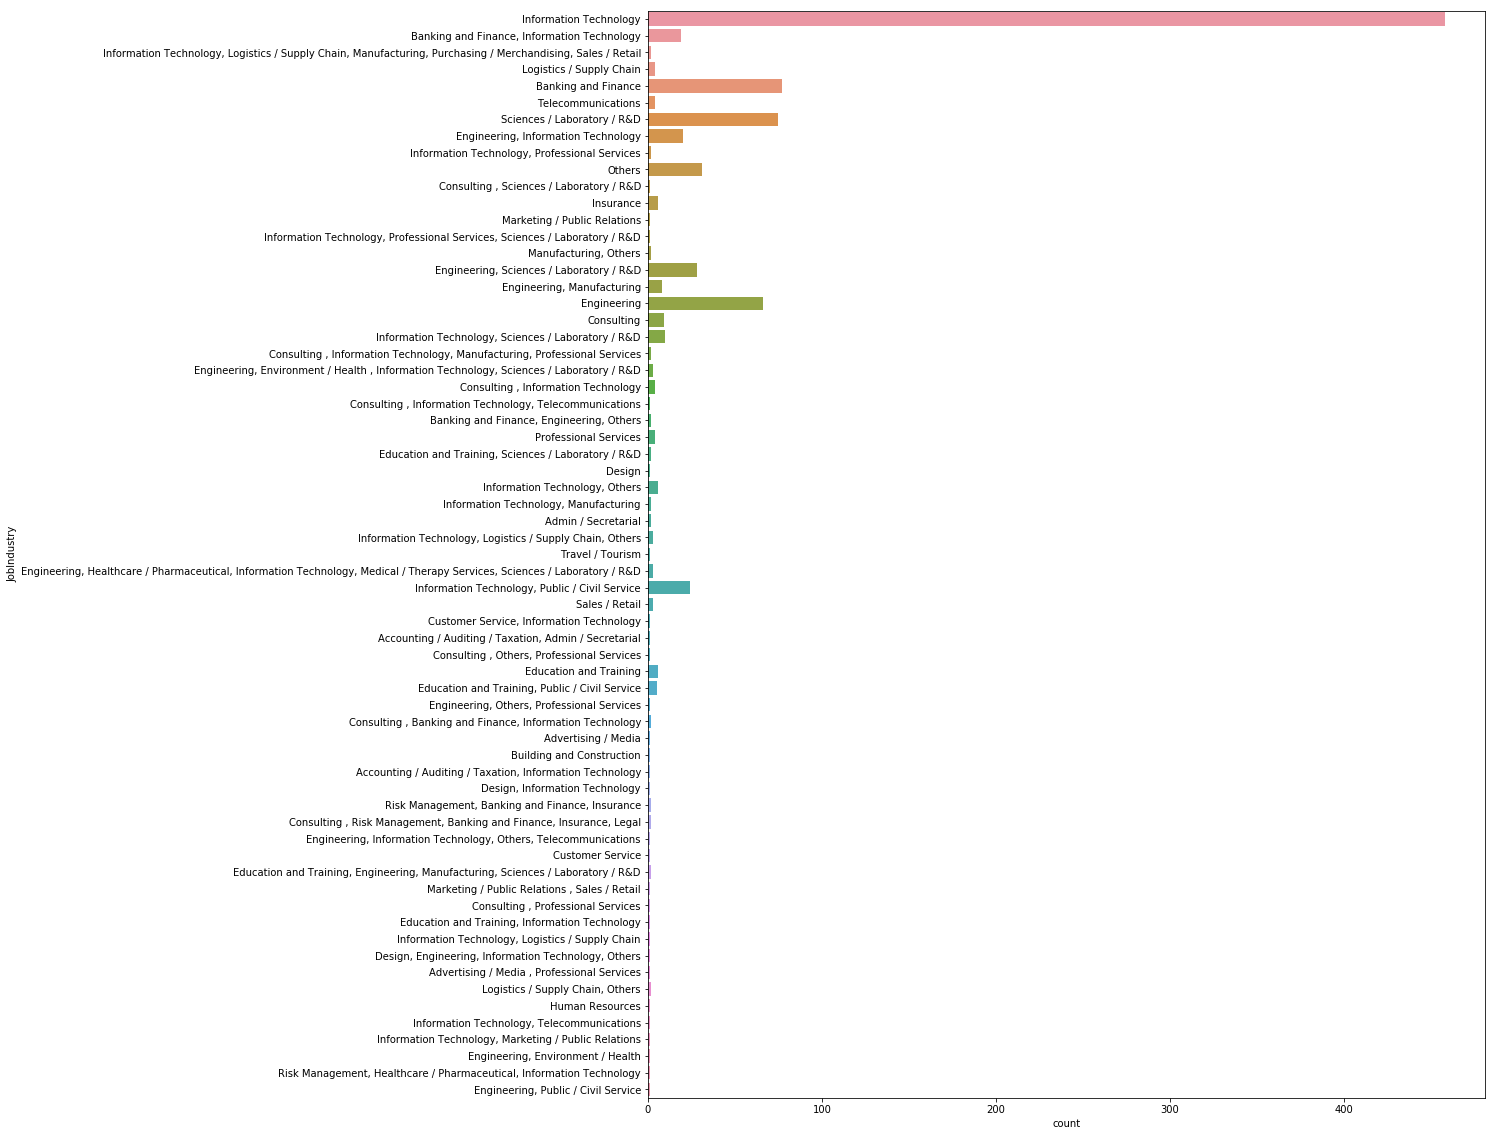

In [27]:
# Plot the Count of Job Industries
plt.figure(figsize=(15,20))
sns_jobtype = sns.countplot(y='JobIndustry', data=df_jobs)

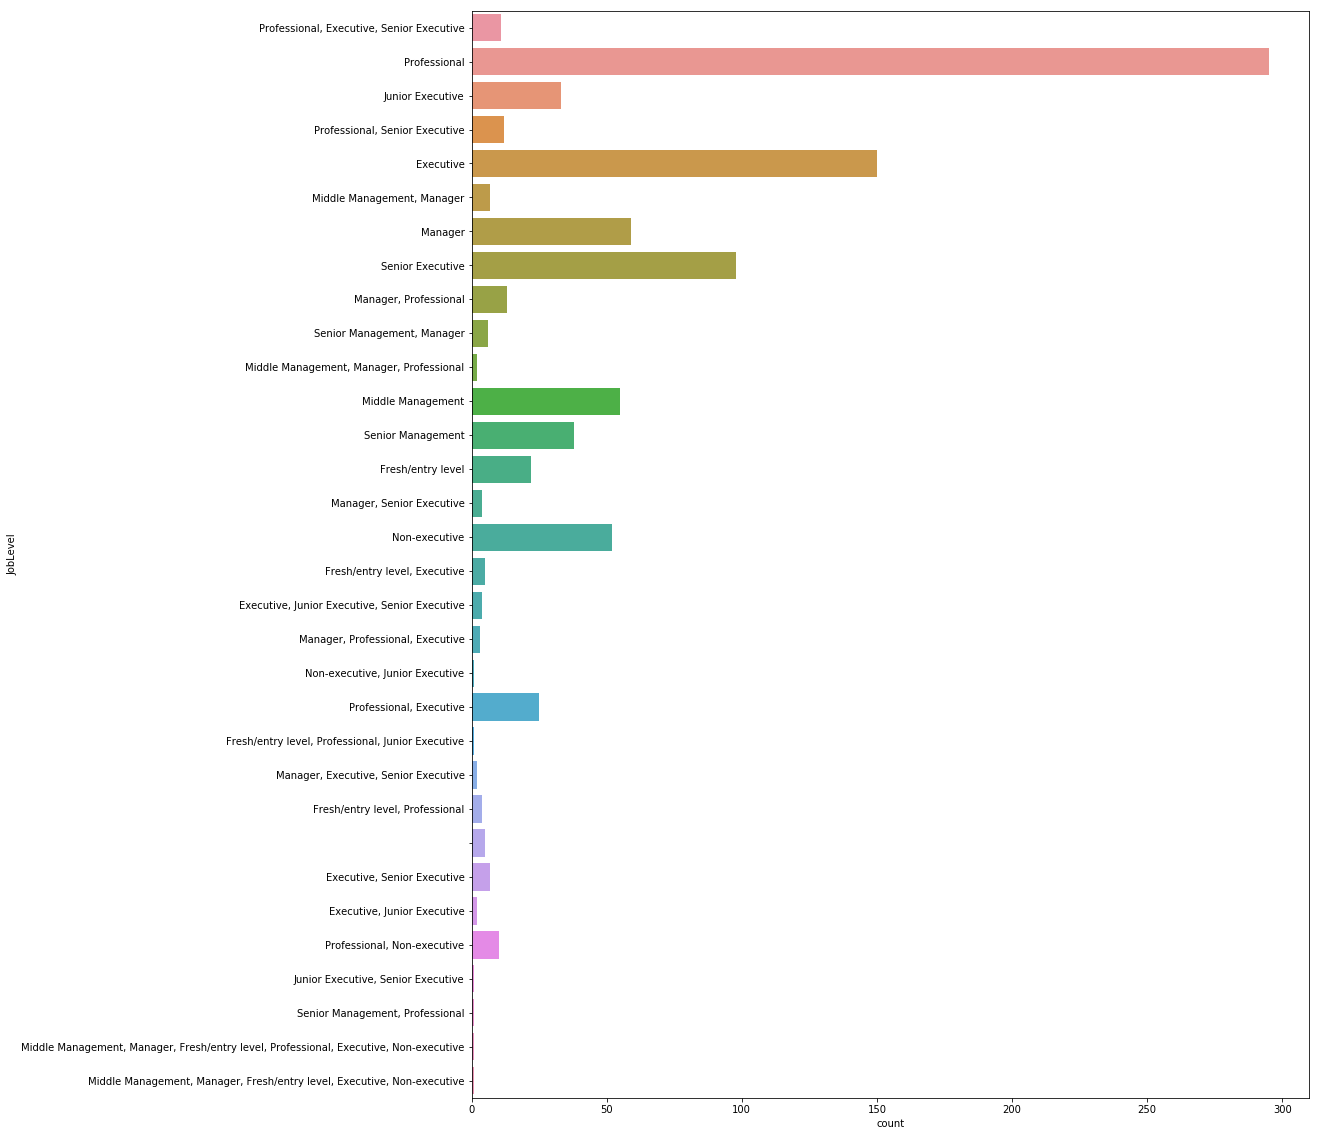

In [28]:
# Plot the Count of Job Levels
plt.figure(figsize=(15,20))
sns_jobtype = sns.countplot(y='JobLevel', data=df_jobs)

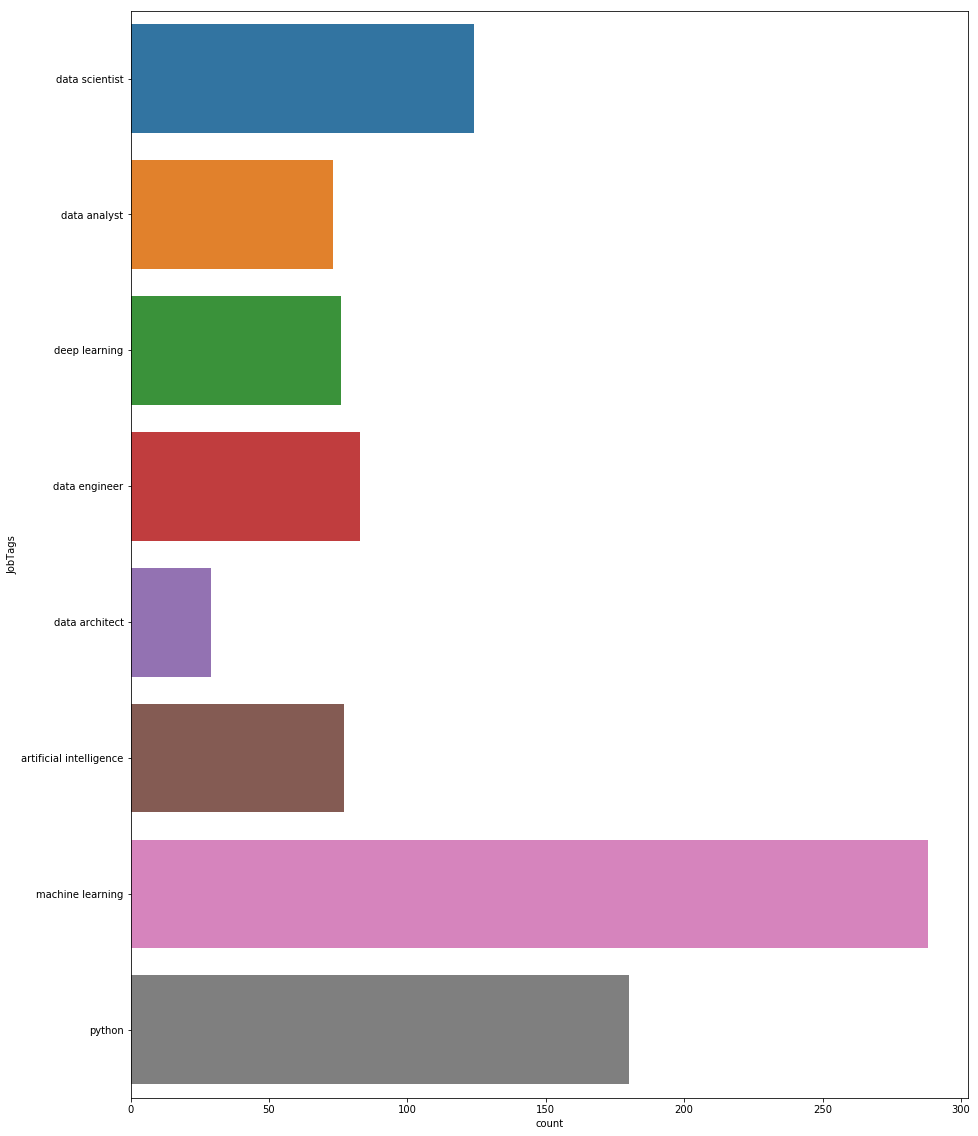

In [29]:
# Plot the Count of Job Tags
plt.figure(figsize=(15,20))
sns_jobtype = sns.countplot(y='JobTags', data=df_jobs)

In [30]:
# Perform text cleaning for Role and Responsibilities columns
df_jobs['Roles'] = df_jobs['Roles'].apply(lambda x: re.sub('\n', ' ', x))
df_jobs['Roles'] = df_jobs['Roles'].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x))
df_jobs['Roles'] = df_jobs['Roles'].apply(lambda x: re.sub('Roles', '', x))
df_jobs['Roles'] = df_jobs['Roles'].apply(lambda x: re.sub('Responsibilities', '', x))

df_jobs['Requirements'] = df_jobs['Requirements'].apply(lambda x: re.sub('\n', ' ', x))
df_jobs['Requirements'] = df_jobs['Requirements'].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x))
df_jobs['Requirements'] = df_jobs['Requirements'].apply(lambda x: re.sub('Roles', '', x))
df_jobs['Requirements'] = df_jobs['Requirements'].apply(lambda x: re.sub('Requirements', '', x))

In [31]:
# Check Sample Record after Cleanup
df_jobs['Roles'][0]

'  In your new role you will Drive prove of concepts build prototypes and solutions and services in Business Analytics encompassing Predictive Prescriptive modelling Anomaly Detection Natural Language Processing Reinforcement Learning Machine learning Deep Neural Networks Responsible for analysis requests from start to finish including requirements gathering conceptualization analyzing and solving Perform Problem Opportunity definition and analysis Collect analyze and interpret qualitative quantitative data with statistical theories and methods Apply standard process CRISP DM business understanding data understanding data preparation modeling evaluation deployment Machine Learning frameworks such as H2O Tensor Flow PyTorch etc Agile Methodologies for Business Analytics projects Build performance metrics dashboard storyboard to present information and insights gathered as part of analysis Create and review technical design documentations researches including proposals white papers prese

In [32]:
df_jobs['Requirements'][0]

' You are best equipped for this task if you have PhD or Masters Degree in Computer Science Mathematics Statistics with at least 5 years of relevant experience Solid understanding and hand on experience in computer vision image recognition deep learning and associated libraries and frameworks Spark Keras Tensorflow OpenCV Skimage etc Good understanding of cloud based AI ML products from Google Amazon IBM AWS and experience in large scale distributed system Hadoop Spark Hbase Experience in developing and debugging in one or more of the following programing language framework Python R C C Scala API ai Cortana Alexa CloudML AureML CoreML TensorFlow Theano Torch Caffe H2O ai etc Good knowledge of Agile Methodologies Experience in best practice adaption and external bench marking Generate intellectual property'

In [33]:
# Drop the ID, URL and Salary since we do not need these columns
df_jobs.drop(columns=['JobId', 'CountryCode', 'JobSite', 'URL'], inplace=True)

In [36]:
df_jobs.columns

Index(['JobTitle', 'Company', 'CompanyAddress', 'JobType', 'JobIndustry',
       'JobLevel', 'SalaryFrom', 'SalaryTo', 'Roles', 'Requirements',
       'JobTags', 'SalaryMean', 'HighSalary'],
      dtype='object')

# Question 1 - Predicting Salary High / Low

## Model 1.1 - JobTags, JobType, JobIndustry

In [ ]:
X_summ11 = df_jobs_nlp[['JobTags', 'JobType', 'JobIndustry']]
y_summ11 = df_jobs_nlp['HighSalary']

In [ ]:
X_summ11 = pd.get_dummies(X_summ11, drop_first=True)
X_summ11.sample(5)

In [ ]:
X_train11, X_test11, y_train11, y_test11 = train_test_split(X_summ11, y_summ11, test_size=0.3,random_state=59, 
                                                            stratify=y_summ11)

In [ ]:
rfc11 = RandomForestClassifier(200, random_state=59, n_jobs=-1)
rfc11.fit(X_train11, y_train11)

rfc_pred11 = rfc11.predict(X_test11)
acc11 = accuracy_score(y_test11, rfc_pred11)
print('Accuracy Score:', acc11.round(3))

s11 = cross_val_score(rfc11, X_summ11, y_summ11.as_matrix(), cv=10, n_jobs=-1)
print('Cross Validation Score: {:0.3} ± {:0.3}'.format(s11.mean().round(3), s11.std().round(3)))

In [ ]:
confusion_matrix(y_test11, rfc_pred11)

In [ ]:
print(classification_report(y_test11, rfc_pred11))

## Model 1.2 - Roles

In [ ]:
X_summ12 = df_jobs_nlp['Roles']
y_summ12 = df_jobs_nlp['HighSalary']

In [ ]:
# Vectorise the Roles and Limit the Words to 2
cv12 = CountVectorizer(stop_words="english", ngram_range=(2,2))
cv12.fit(X_summ12)

In [ ]:
len(cv12.get_feature_names())

In [ ]:
X_summ_trans12 = pd.DataFrame(cv12.transform(X_summ12).todense(), columns=cv12.get_feature_names())

In [ ]:
X_train12, X_test12, y_train12, y_test12 = train_test_split(np.asmatrix(X_summ_trans12), y_summ12, test_size=0.3, 
                                                            random_state=59, stratify=y_summ12)

In [ ]:
word_counts12 = X_summ_trans12.sum(axis=0)
word_counts12.sort_values(ascending = False).head(20)

In [ ]:
rfc12 = RandomForestClassifier(200, random_state=59, n_jobs=-1)
rfc12.fit(X_train12, y_train12)

rfc_pred12 = rfc12.predict(X_test12)
acc12 = accuracy_score(y_test12, rfc_pred12)
print('Accuracy Score:', acc12.round(3))

s12 = cross_val_score(rfc12, X_summ_trans12.as_matrix(), y_summ12.as_matrix(), cv=10, n_jobs=-1)
print('Cross Validation Score: {:0.3} ± {:0.3}'.format(s12.mean().round(3), s12.std().round(3)))

In [ ]:
confusion_matrix(y_test12, rfc_pred12)

In [ ]:
print(classification_report(y_test12, rfc_pred12))

## Model 1.3 - Requirements

In [ ]:
X_summ13 = df_jobs_nlp['Requirements']
y_summ13 = df_jobs_nlp['HighSalary']

In [ ]:
cv13 = CountVectorizer(stop_words="english", ngram_range=(2,2))
cv13.fit(X_summ13)

In [ ]:
len(cv13.get_feature_names())

In [ ]:
X_summ_trans13 = pd.DataFrame(cv13.transform(X_summ13).todense(), columns=cv13.get_feature_names())

In [ ]:
X_train13, X_test13, y_train13, y_test13 = train_test_split(np.asmatrix(X_summ_trans13), y_summ13, test_size=0.3, 
                                                            random_state=59, stratify=y_summ13)

In [ ]:
word_counts13 = X_summ_trans13.sum(axis=0)
word_counts13.sort_values(ascending = False).head(20)

In [ ]:
rfc13 = RandomForestClassifier(200, random_state=59, n_jobs=-1)
rfc13.fit(X_train13, y_train13)

rfc_pred13 = rfc13.predict(X_test13)
acc13 = accuracy_score(y_test13, rfc_pred13)
print('Accuracy Score:', acc13.round(3))

s13 = cross_val_score(rfc13, X_summ_trans13.as_matrix(), y_summ13.as_matrix(), cv=10, n_jobs=-1)
print('Cross Validation Score: {:0.3} ± {:0.3}'.format(s13.mean().round(3), s13.std().round(3)))

In [ ]:
confusion_matrix(y_test13, rfc_pred13)

In [ ]:
print(classification_report(y_test13, rfc_pred13))

## Extra for Question 1
## Model 1.1.1 - What if SalaryMean is to be predicted using Model 1.1 Features (JobTags, JobType and JobIndustry)?

In [ ]:
X_summ114 = df_jobs_nlp[['JobTags', 'JobType', 'JobIndustry']]
y_summ114 = df_jobs_nlp['SalaryMean']

In [ ]:
X_summ114 = pd.get_dummies(X_summ114, drop_first=True)
X_summ114.sample(5)

In [ ]:
X_summ114.shape

In [ ]:
X_train114, X_test114, y_train114, y_test114 = train_test_split(X_summ114, y_summ114, test_size=0.4, random_state=59)

In [ ]:
rfr = RandomForestRegressor(n_estimators=100, random_state=59, oob_score=True, min_samples_split=100, criterion='mse', n_jobs=-1)
rfr.fit(X_train114, y_train114)

In [ ]:
rfr_pred = rfr.predict(X_test114)

In [ ]:
r2_score(y_test114, rfr_pred)

In [ ]:
mean_squared_error(y_test114, rfr_pred)

In [ ]:
mean_absolute_error(y_test114, rfr_pred)

# Question 2 - Predicting Job Categories

## Model 2.1 - Predict JobTags using Requirements

In [ ]:
X_summ21 = df_jobs_nlp['Requirements']
y_summ21 = df_jobs_nlp['JobTags']

In [ ]:
cv21 = CountVectorizer(stop_words="english", ngram_range=(2,2))
cv21.fit(X_summ21)

In [ ]:
len(cv21.get_feature_names())

In [ ]:
X_summ_trans21 = pd.DataFrame(cv21.transform(X_summ21).todense(), columns=cv21.get_feature_names())

In [ ]:
X_train21, X_test21, y_train21, y_test21 = train_test_split(np.asmatrix(X_summ_trans21), y_summ21, test_size=0.3, 
                                                            random_state=59, stratify=y_summ21)

In [ ]:
word_counts21 = X_summ_trans21.sum(axis=0)
word_counts21.sort_values(ascending = False).head(20)

In [ ]:
rfc21 = RandomForestClassifier(200, random_state=59, n_jobs=-1)
rfc21.fit(X_train21, y_train21)

rfc_pred21 = rfc21.predict(X_test21)
acc21 = accuracy_score(y_test21, rfc_pred21)
print('Accuracy Score:', acc21.round(3))

s21 = cross_val_score(rfc21, X_summ_trans21.as_matrix(), y_summ21.as_matrix(), cv=10, n_jobs=-1)
print('Cross Validation Score: {:0.3} ± {:0.3}'.format(s21.mean().round(3), s21.std().round(3)))

In [ ]:
confusion_matrix(y_test21, rfc_pred21)

In [ ]:
print(classification_report(y_test21, rfc_pred21))

## Model 2.2 - Predict JobTypes using Requirements

In [ ]:
X_summ22 = df_jobs_nlp['Requirements']
y_summ22 = df_jobs_nlp['JobType']

In [ ]:
cv22 = CountVectorizer(stop_words="english", ngram_range=(2,2))
cv22.fit(X_summ22)

In [ ]:
len(cv22.get_feature_names())

In [ ]:
X_summ_trans22 = pd.DataFrame(cv22.transform(X_summ22).todense(), columns=cv22.get_feature_names())

In [ ]:
X_train22, X_test22, y_train22, y_test22 = train_test_split(np.asmatrix(X_summ_trans22), y_summ22, test_size=0.3, 
                                                            random_state=59)

In [ ]:
word_counts22 = X_summ_trans22.sum(axis=0)
word_counts22.sort_values(ascending = False).head(20)

In [ ]:
rfc22 = RandomForestClassifier(200, random_state=59, n_jobs=-1)
rfc22.fit(X_train22, y_train22)

rfc_pred22 = rfc22.predict(X_test22)
acc22 = accuracy_score(y_test22, rfc_pred22)
print('Accuracy Score:', acc22.round(3))

s22 = cross_val_score(rfc22, X_summ_trans22.as_matrix(), y_summ22.as_matrix(), cv=10, n_jobs=-1)
print('Cross Validation Score: {:0.3} ± {:0.3}'.format(s22.mean().round(3), s22.std().round(3)))

In [ ]:
confusion_matrix(y_test22, rfc_pred22)

In [ ]:
print(classification_report(y_test22, rfc_pred22))

# BONUS

## Model 3.1 - Use Model 1.3 (Salary Classification using Requirements)
#### Use this model since it gives the best score in Question 1 but this time adjust the class weight of the model to give more weight to High Salary and check the impact on precision and recall

In [ ]:
X_summ31 = df_jobs_nlp['Requirements']
y_summ31 = df_jobs_nlp['HighSalary']

In [ ]:
cv31 = CountVectorizer(stop_words="english", ngram_range=(2,2))
cv31.fit(X_summ31)

In [ ]:
len(cv31.get_feature_names())

In [ ]:
X_summ_trans31 = pd.DataFrame(cv31.transform(X_summ31).todense(), columns=cv31.get_feature_names())

In [ ]:
X_train31, X_test31, y_train31, y_test31 = train_test_split(np.asmatrix(X_summ_trans31), y_summ31, test_size=0.3, 
                                                            random_state=59, stratify=y_summ31)

In [ ]:
word_counts31 = X_summ_trans31.sum(axis=0)
word_counts31.sort_values(ascending = False).head(20)

In [ ]:
rfc31 = RandomForestClassifier(200, random_state=59, class_weight={0: 1, 1: 3}, n_jobs=-1)
rfc31.fit(X_train31, y_train31)

rfc_pred31 = rfc31.predict(X_test31)
acc31 = accuracy_score(y_test31, rfc_pred31)
print('Accuracy Score:', acc31.round(3))

s31 = cross_val_score(rfc31, X_summ_trans31.as_matrix(), y_summ31.as_matrix(), cv=10, n_jobs=-1)
print('Cross Validation Score: {:0.3} ± {:0.3}'.format(s31.mean().round(3), s31.std().round(3)))

In [ ]:
confusion_matrix(y_test31, rfc_pred31)

In [ ]:
print(classification_report(y_test31, rfc_pred31))

#### Compare the New Model with Model 1.3

In [ ]:
confusion_matrix(y_test13, rfc_pred13)

In [ ]:
print(classification_report(y_test13, rfc_pred13))

In [ ]:
# Plot the ROC Curve of Model 1.3
fpr13, tpr13, threshold13 = roc_curve(y_test13, rfc_pred13)
roc_auc13 = auc(fpr13, tpr13)

plt.figure(figsize=(15,7))
plt.title('Receiver Operating Characteristic Model 1.3')
plt.plot(fpr13, tpr13, 'b', label = ['AUC = %0.2f' % roc_auc13])
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# Impose the New ROC Curve from the New Model to Compare
fpr31, tpr31, threshold31 = roc_curve(y_test31, rfc_pred31)
roc_auc31 = auc(fpr31, tpr31)

plt.figure(figsize=(15,7))
plt.title('Receiver Operating Characteristic Model 1.3 vs Model 3.1')
plt.plot(fpr13, tpr13, 'b', label = ['AUC = %0.2f' % roc_auc13])
plt.plot(fpr31, tpr31, 'g', label = ['AUC = %0.2f' % roc_auc31])
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()